# Exploration

In [1]:
import time
import os
# os.environ["MKL_THREADING_LAYER"] = "GNU"
import keras
# import theano
import tensorflow
import numpy as np
import pandas as pd
import decimal
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from sklearn.utils import shuffle
from keras.layers import Dense, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Sequential

# Set the randomizer seed so results are the same each time.
np.random.seed(0)
pd.options.display.max_columns = 30
print('keras version:', keras.__version__)
print('tensorflow version:', tensorflow.__version__)
print('pandas version:', pd.__version__)
print('numpy version:', np.__version__)

C:\Users\alexd\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


keras version: 2.2.4
tensorflow version: 1.12.0
pandas version: 0.23.0
numpy version: 1.14.3


### Examine the data

In [24]:
train = pd.read_csv('training.csv')
train['Image'] = train.Image.apply(lambda im: np.fromstring(im, sep=' '))
full_data = train.Image
full_labels = train[train.columns[:-1]]
features = full_labels.columns

In [4]:
print(train.count())

left_eye_center_x            7039
left_eye_center_y            7039
right_eye_center_x           7036
right_eye_center_y           7036
left_eye_inner_corner_x      2271
left_eye_inner_corner_y      2271
left_eye_outer_corner_x      2267
left_eye_outer_corner_y      2267
right_eye_inner_corner_x     2268
right_eye_inner_corner_y     2268
right_eye_outer_corner_x     2268
right_eye_outer_corner_y     2268
left_eyebrow_inner_end_x     2270
left_eyebrow_inner_end_y     2270
left_eyebrow_outer_end_x     2225
left_eyebrow_outer_end_y     2225
right_eyebrow_inner_end_x    2270
right_eyebrow_inner_end_y    2270
right_eyebrow_outer_end_x    2236
right_eyebrow_outer_end_y    2236
nose_tip_x                   7049
nose_tip_y                   7049
mouth_left_corner_x          2269
mouth_left_corner_y          2269
mouth_right_corner_x         2270
mouth_right_corner_y         2270
mouth_center_top_lip_x       2275
mouth_center_top_lip_y       2275
mouth_center_bottom_lip_x    7016
mouth_center_b

In [5]:
full_labels.sample(10)

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,right_eye_outer_corner_x,right_eye_outer_corner_y,left_eyebrow_inner_end_x,left_eyebrow_inner_end_y,left_eyebrow_outer_end_x,left_eyebrow_outer_end_y,right_eyebrow_inner_end_x,right_eyebrow_inner_end_y,right_eyebrow_outer_end_x,right_eyebrow_outer_end_y,nose_tip_x,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y
4411,71.079000,39.584208,26.331576,38.054388,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,47.366640,69.798240,NaN,NaN,NaN,NaN,NaN,NaN,46.984200,81.271920
4901,64.399591,38.503814,29.440197,39.945433,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,46.739687,63.732223,NaN,NaN,NaN,NaN,NaN,NaN,48.181306,75.265206
6794,69.260800,40.359393,28.490869,36.186097,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,45.826152,75.671945,NaN,NaN,NaN,NaN,NaN,NaN,45.184110,84.981572
2724,73.352348,38.401461,32.468452,38.401461,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,49.224209,76.604661,NaN,NaN,NaN,NaN,NaN,NaN,49.894330,88.668730
6648,65.515296,36.871904,29.650475,40.187136,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,51.350197,66.106251,NaN,NaN,NaN,NaN,NaN,NaN,52.254357,77.558827
5633,63.327308,38.484376,35.244195,39.906318,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,49.463611,59.102426,NaN,NaN,NaN,NaN,NaN,NaN,48.752692,70.833366
526,66.328960,36.912768,32.007040,35.196608,59.751040,38.342848,71.477760,37.198784,36.869120,36.912768,25.428480,34.910592,55.460480,30.048256,77.484160,28.046144,38.013440,29.476224,19.422080,26.902016,45.163520,62.940800,58.606720,76.955520,31.434880,75.811840,45.163520,74.095360,44.019840,84.392320
296,64.918419,38.881725,28.223425,36.297772,58.457677,39.399090,71.378587,39.915880,33.908695,37.331353,22.280048,36.556455,57.424096,30.354395,79.647808,33.713763,36.751329,27.253423,15.819880,25.702937,45.278659,59.813174,56.907305,83.587257,32.616431,82.295569,45.278659,77.385772,45.278659,92.373269
5649,64.263628,35.499572,31.193526,38.590214,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,46.955944,65.788019,NaN,NaN,NaN,NaN,NaN,NaN,50.355572,82.786605
2162,67.690269,35.696894,29.502277,37.127950,60.322981,36.359420,75.983503,37.477234,39.095652,37.684472,21.211694,39.522054,58.173582,29.979931,79.683431,30.736394,40.084259,31.229739,19.396652,30.506166,49.396330,60.597097,68.056859,71.180585,33.458101,74.460088,50.136717,76.991396,49.879042,77.060266


### Look at some examples of missing labels

In [7]:
def plot_sample(data, labels):
    '''
    data must be a numpy.ndarray of shape (16, 9216)
    labels must be a numpy.ndarray (16, 30)
    the indices must line up between the two
    '''
    
    fig = plt.figure(figsize=(10,10))
    fig.subplots_adjust(left=0, right=1, 
                        bottom=0, top=1, 
                        hspace=0.05, wspace=0.05)
    for i in range(labels.shape[0]):
        img = data[i].reshape(96,96)
        ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
        ax.imshow(data[i].reshape(96,96), cmap='gray')
        ax.scatter(labels[i][0::2] * 48 + 48, 
                   labels[i][1::2] * 48 + 48, c='r')

In [7]:
missing_labels = full_labels[pd.isna(full_labels.left_eye_inner_corner_x)]
idx = missing_labels.sample(16).index.values

In [8]:
missing_labels_sample = missing_labels.loc[idx]
missing_labels_sample

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,right_eye_outer_corner_x,right_eye_outer_corner_y,left_eyebrow_inner_end_x,left_eyebrow_inner_end_y,left_eyebrow_outer_end_x,left_eyebrow_outer_end_y,right_eyebrow_inner_end_x,right_eyebrow_inner_end_y,right_eyebrow_outer_end_x,right_eyebrow_outer_end_y,nose_tip_x,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y
4766,65.849805,36.064320,30.786035,37.224230,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,47.411379,63.902093,NaN,NaN,NaN,NaN,NaN,NaN,48.184653,73.954624
3198,68.605471,37.497074,30.937084,37.287809,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.608258,63.655665,NaN,NaN,NaN,NaN,NaN,NaN,49.980542,78.932284
3665,67.603547,39.496598,30.348607,35.238940,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,44.186140,68.590959,NaN,NaN,NaN,NaN,NaN,NaN,43.121696,77.815865
2341,66.190080,40.266831,29.448738,39.149612,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.231705,69.585674,NaN,NaN,NaN,NaN,NaN,NaN,49.489477,78.863778
2983,65.931345,36.832785,27.610327,36.832785,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,48.931782,67.374255,NaN,NaN,NaN,NaN,NaN,NaN,48.643636,82.068800
3779,68.275238,39.425990,34.841587,35.492621,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,53.852870,62.370643,NaN,NaN,NaN,NaN,NaN,NaN,52.213978,73.515206
4997,64.061982,39.366823,28.532086,38.911311,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,46.752443,63.964490,NaN,NaN,NaN,NaN,NaN,NaN,46.296960,71.252677
3243,69.288000,46.060465,29.645247,35.158705,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,38.812577,76.783702,NaN,NaN,NaN,NaN,NaN,NaN,31.627312,88.428726
4640,62.035446,37.299963,35.725538,38.944320,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,48.880492,57.032320,NaN,NaN,NaN,NaN,NaN,NaN,49.702646,66.076308
6141,63.051757,44.531530,33.423861,39.954877,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,48.358226,70.064452,NaN,NaN,NaN,NaN,NaN,NaN,43.540696,83.553600


In [9]:
missing_data = full_data.loc[missing_labels.index.values]
missing_data_sample = missing_data.loc[idx].values

In [10]:
missing_labels_sample = (missing_labels_sample.values - 48) / 48

In [8]:
plot_sample(missing_data_sample, missing_labels_sample)

NameError: name 'missing_data_sample' is not defined

### Load the data for real

In [2]:
def load_data(test=False):
    
    # load the raw data
    if test: df = pd.read_csv('test.csv')
    else: df = pd.read_csv('training.csv')
    
    # convert the image format
    df['Image'] = df.Image.apply(lambda im: np.fromstring(im, sep=' '))
    
    # drop missing values
    df = df.dropna()
    
    # separate data and reshape the images
    data = df.Image.values
    data = np.stack(data) / 255
    data = data.reshape(-1, 96, 96, 1)
    
    # separate the labels and scale them to [-1,1] interval
    if test:
        labels = None
        print(data.shape)
    else:
        labels = df[df.columns[:-1]].values
        labels = (labels - 48) / 48
        data, labels = shuffle(data, labels, random_state=666)
        print(data.shape, labels.shape)
    
    return data, labels

In [3]:
train_data, train_labels = load_data()

(2140, 96, 96, 1) (2140, 30)


### Print some examples

In [4]:
idx = np.random.randint(0, len(train_data), 16)

In [5]:
data_sample = train_data[idx, :, :, :]
label_sample = train_labels[idx, :]

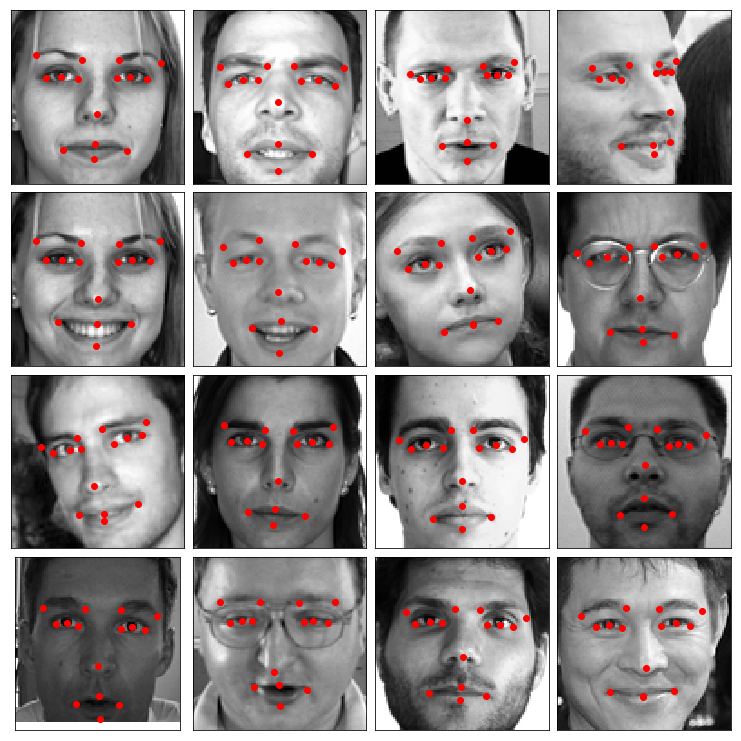

In [9]:
plot_sample(data_sample, label_sample)

## Mirror images to create larger training set

In [98]:
def flip_data(data, labels, features):
    # flip the images
    data_flipped = data[:, :, ::-1, :]
    
    # flip the labels
    labels_flipped = np.zeros(labels.shape)
    for idx in range(len(labels)):
        for i,s1 in enumerate(features):
            parts = s1.partition('_')
            if parts[0] == 'left' or parts[0] == 'right':
                coord = parts[-1]
            elif parts[0] == 'mouth':
                parts = s1.split('_', maxsplit=2)
                if 'corner' in parts[-1]:
                    coord = parts[-1]        
                elif 'x' in parts[-1]:
                    labels_flipped[idx,i] = labels[idx,i] * -1
                else:
                    labels_flipped[idx,i] = labels[idx,i]
            else:
                if 'x' in parts[-1]:
                    labels_flipped[idx,i] = labels[idx,i] * -1
                else:
                    labels_flipped[idx,i] = labels[idx,i]
            for j in range(i+1,len(features)-1):
                s2 = features[j]
                if coord in s2:
                    if 'x' in coord:
                        labels_flipped[idx,i] = labels[idx,j] * -1
                        labels_flipped[idx,j] = labels[idx,i] * -1
                    else:
                        labels_flipped[idx,i] = labels[idx,j]
                        labels_flipped[idx,j] = labels[idx,i]
                
    return data_flipped, labels_flipped

In [100]:
train_data_flipped, train_labels_flipped = flip_data(train_data, train_labels, list(features_full.copy()))

In [54]:
idx = np.random.randint(0, len(train_data), 16)

In [87]:
data_sample = train_data[idx, :, :, :]
label_sample = train_labels[idx, :]

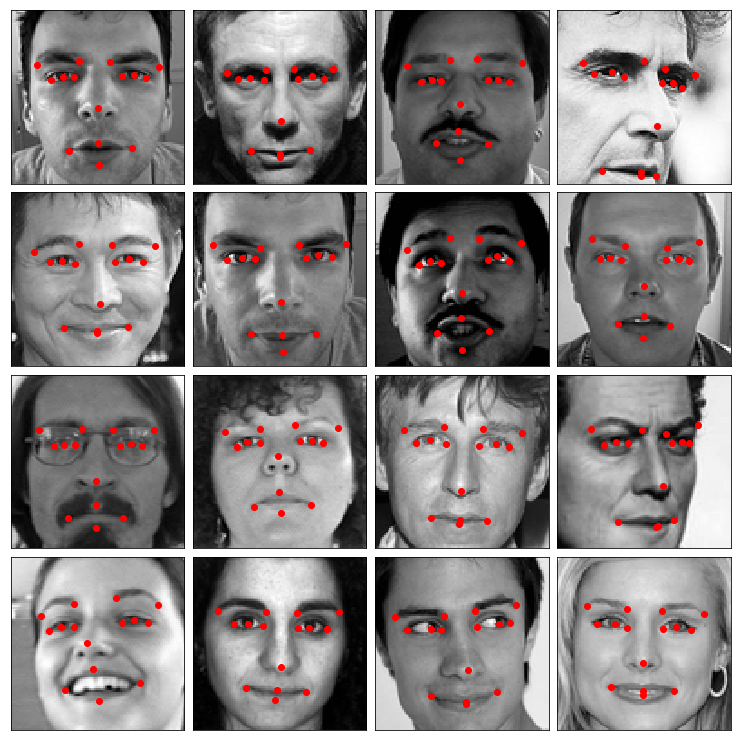

In [101]:
plot_sample(data_sample, label_sample)

In [102]:
data_sample_flipped = train_data_flipped[idx, :, :, :]
label_sample_flipped = train_labels_flipped[idx, :]

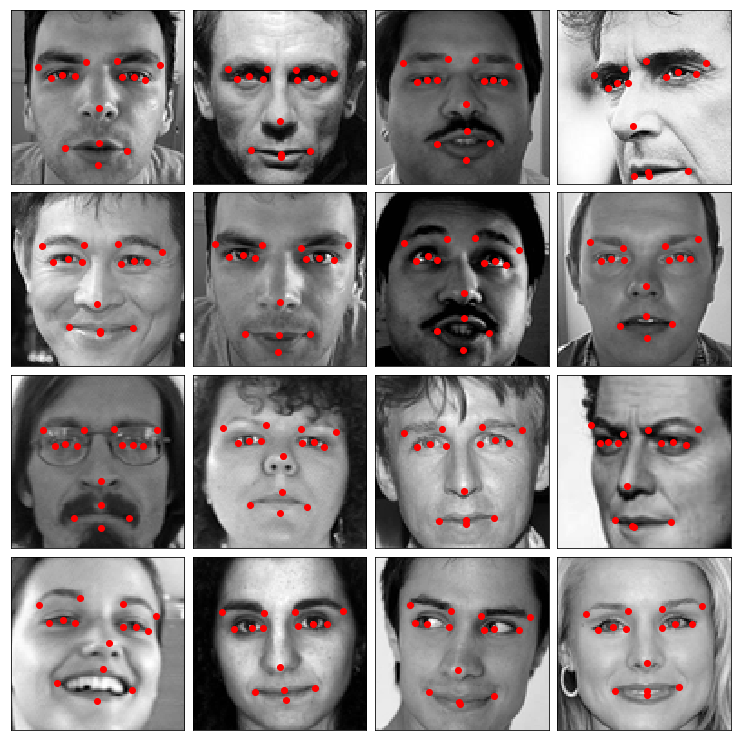

In [103]:
plot_sample(data_sample_flipped, label_sample_flipped)

## Combine mirrored and original data

In [105]:
train_data_set = np.concatenate((train_data, train_data_flipped), axis=0)
train_data.shape, train_data_flipped.shape, train_data_set.shape

((2140, 96, 96, 1), (2140, 96, 96, 1), (4280, 96, 96, 1))

In [107]:
train_labels_set = np.concatenate((train_labels, train_labels_flipped), axis=0)
train_labels.shape, train_labels_flipped.shape, train_labels_set.shape

((2140, 30), (2140, 30), (4280, 30))

# Recreate Daniel Nouri model in Keras

## Original Model

In [29]:
model = Sequential()

# first group of layers
model.add(Conv2D(
    32, 
    kernel_size=(3,3), 
    activation='relu',
    input_shape=(96, 96, 1), 
#     data_format='channels_first'
))
model.add(MaxPooling2D(pool_size=(2, 2)))

# second group of layers
model.add(Conv2D(
    64, 
    kernel_size=(2, 2), 
    activation='relu'
))
model.add(MaxPooling2D(pool_size=(2, 2)))

# third group of layers
model.add(Conv2D(
    128, 
    kernel_size=(2, 2), 
    activation='relu'
))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(500, activation='relu'))
model.add(Dense(500, activation='relu'))
model.add(Dense(30))

# sgd = keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
adagrad = keras.optimizers.Adagrad(lr=0.01, epsilon=None, decay=0.0)
model.compile(loss='mean_squared_error', optimizer=adagrad)

In [30]:
time_callback = TimeHistory()
hist = model.fit(
    train_data, train_labels, 
    batch_size=32,
    epochs=4,
    validation_split=0.2, 
    verbose=1,
    callbacks=[keras.callbacks.History(), time_callback]
)
print('RMS error on validation set:', np.sqrt(hist.history['val_loss'][-1]) * 48)
print('Total runtime (minutes):', round(np.sum(time_callback.times) / 60, 2))

Train on 1712 samples, validate on 428 samples
Epoch 1/4
1712/1712 [==============================] - 27s 16ms/step - loss: 64.8043 - val_loss: 0.0078
Epoch 2/4
1712/1712 [==============================] - 25s 15ms/step - loss: 0.0061 - val_loss: 0.0048
Epoch 3/4
1712/1712 [==============================] - 25s 15ms/step - loss: 0.0049 - val_loss: 0.0045
Epoch 4/4
1712/1712 [==============================] - 26s 15ms/step - loss: 0.0046 - val_loss: 0.0043
RMS error on validation set: 3.162492642692301
Total runtime (minutes): 1.73


## Me trying to understand...

In [108]:
# making a callback so I can compare runtimes
class TimeHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

In [124]:
model = Sequential()

# FIRST CONVOLUTIONAL LAYER
model.add(Conv2D(
    filters=32, # don't yet fully understand how to choose this dimension
    kernel_size=(3,3),
    strides=(1,1),
    padding='same',
    activation='relu',
    input_shape=(96, 96, 1),
))
# input_shape = (batch, rows, cols, channels) --> (batch, 96, 96, 1)
# padding = 'same' so for a kernel of size (3,3) and strides=(1,1) this 
# will pad two rows and two columns of zeros on the edges so that the 
# output shape gives an tensor with 96 rows and 96 columns
# output_shape = (batch, new_rows, new_cols, filters) --> (batch, 96, 96, 32)

# POOLING LAYER
model.add(MaxPooling2D(
    pool_size=(2,2),
    strides=None
))
# setting strides=None sets the strides to a default of pool_size, so 
# here we are really setting strides=(2,2) which is what we want so we 
# don't miss any pixels and we don't count any pixels more than once
# the strides is essentially the factor by which to downscale the output
# so setting the strides=(2,2) will have the dimensions of input
# output_shape = (batch, in_rows/strides[0], in_cols/strides[1], filters) --> (batch, 48, 48, 32)


# SECOND CONVOLUTIONAL LAYER
model.add(Conv2D(
    filters=64, # don't know why we increased this number by 2
#     kernel_size=(2, 2),
    kernel_size=(3, 3),
    strides=(1,1),
    padding='same',
    activation='relu'
))
# input_shape = (batch, pool_rows, pool_cols, in_filters) --> (batch, 48, 48, 32)
# output_shape = (batch, new_rows, new_cols, out_filters) --> (batch, 48, 48, 64)

# SECOND POOLING LAYER
model.add(MaxPooling2D(
    pool_size=(2, 2), 
    strides=None
))
# input_shape = (batch, in_rows, in_cols, filters) --> (batch, 48, 48, 64)
# output_shape = (batch, in_rows/strides[0], in_cols/strides[1], filters) --> (batch, 24, 24, 64)

# THIRD CONVOLUTIONAL LAYER
model.add(Conv2D(
    filters=128, # don't know how to choose this value
#     kernel_size=(2, 2),
    kernel_size=(3, 3),
    strides=(1,1),
    padding='same',
    activation='relu'
))
# input_shape = (batch, pool_rows, pool_cols, in_filters) --> (batch, 24, 24, 64)
# output_shape = (batch, new_rows, new_cols, out_filters) --> (batch, 24, 24, 128)

# THIRD POOLING LAYER
model.add(MaxPooling2D(
    pool_size=(2, 2),
    strides=None
))
# input_shape = (batch, in_rows, in_cols, filters) --> (batch, 24, 24, 128)
# output_shape = (batch, in_rows/strides[0], in_cols/strides[1], filters) --> (batch, 12, 12, 128)

# FLATTEN THE POOLED OUTPUT TO CLASSIFY
model.add(Flatten())
# flatten the output into a single layer of 
#     shape = [batch, pool_rows * pool_cols * in_filters]
#         --> [batch, 12 * 12 * 128] = [batch, 18432]

# ADD ONE FULLY CONNECTED LAYER TO PROCESS THE FLATTENED DATA
model.add(Dense(
#     500,
    1000,
    activation='relu'
))
# input_shape = [batch, flattened_nodes] = [batch, 18432]
# output_shape = [batch, out_nodes] = [batch, 500]

# FINAL OUTPUT LAYER
model.add(Dense(30))
# input_shape = [batch, in_nodes] = [batch, 500]
# output_shape = [batch, num_classes] = [batch, 30]

# opt = keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
# opt = keras.optimizers.Adagrad()
opt = keras.optimizers.Nadam()
model.compile(loss='mean_squared_error', optimizer=opt)

In [119]:
time_callback = TimeHistory()
hist1 = model.fit(
    train_data, train_labels, 
    batch_size=32,
    epochs=10, 
    validation_split=0.2, 
    verbose=1,
    callbacks=[keras.callbacks.History(), time_callback]
)
print('\nRMS error on validation set:', np.sqrt(hist1.history['val_loss'][-1]) * 48)
print('Total runtime (minutes):', round(np.sum(time_callback.times) / 60, 2))

Train on 1712 samples, validate on 428 samples
Epoch 1/10
1712/1712 [==============================] - 54s 31ms/step - loss: 0.1865 - val_loss: 0.0062
Epoch 2/10
1712/1712 [==============================] - 49s 29ms/step - loss: 0.0060 - val_loss: 0.0047
Epoch 3/10
1712/1712 [==============================] - 49s 29ms/step - loss: 0.0050 - val_loss: 0.0037
Epoch 4/10
1712/1712 [==============================] - 50s 29ms/step - loss: 0.0041 - val_loss: 0.0036
Epoch 5/10
1712/1712 [==============================] - 50s 29ms/step - loss: 0.0034 - val_loss: 0.0032
Epoch 6/10
1712/1712 [==============================] - 52s 30ms/step - loss: 0.0030 - val_loss: 0.0027
Epoch 7/10
1712/1712 [==============================] - 54s 31ms/step - loss: 0.0024 - val_loss: 0.0035
Epoch 8/10
1712/1712 [==============================] - 53s 31ms/step - loss: 0.0023 - val_loss: 0.0027
Epoch 9/10
1712/1712 [==============================] - 51s 30ms/step - loss: 0.0018 - val_loss: 0.0019
Epoch 10/10
1712/

In [127]:
print('\nRMS error on validation set:', np.sqrt(hist1.history['val_loss'][-1]) * 48)


RMS error on validation set: 2.18464780513732


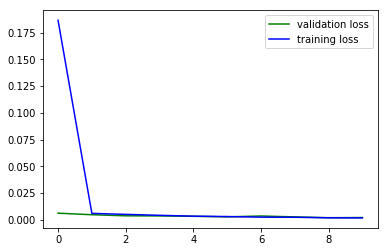

In [120]:
val_rms = np.sqrt(hist1.history['val_loss']) * 48
train_rms = np.sqrt(hist1.history['loss']) * 48

plt.plot(val_rms, 'g-')
plt.plot(train_rms, 'b-')
plt.legend(['validation loss','training loss'])

In [125]:
time_callback = TimeHistory()
hist2 = model.fit(
    train_data_set, train_labels_set, 
    batch_size=32,
    epochs=10, 
    validation_split=0.2, 
    verbose=1,
    callbacks=[keras.callbacks.History(), time_callback]
)
print('\nRMS error on validation set:', np.sqrt(hist2.history['val_loss'][-1]) * 48)
print('Total runtime (minutes):', round(np.sum(time_callback.times) / 60, 2))

Train on 3424 samples, validate on 856 samples
Epoch 1/10
3424/3424 [==============================] - 118s 34ms/step - loss: 0.0931 - val_loss: 0.0047
Epoch 2/10
3424/3424 [==============================] - 135s 39ms/step - loss: 0.0050 - val_loss: 0.0036
Epoch 3/10
3424/3424 [==============================] - 136s 40ms/step - loss: 0.0037 - val_loss: 0.0025
Epoch 4/10
3424/3424 [==============================] - 136s 40ms/step - loss: 0.0027 - val_loss: 0.0019
Epoch 5/10
3424/3424 [==============================] - 106s 31ms/step - loss: 0.0021 - val_loss: 0.0029
Epoch 6/10
3424/3424 [==============================] - 100s 29ms/step - loss: 0.0019 - val_loss: 0.0015
Epoch 7/10
3424/3424 [==============================] - 108s 32ms/step - loss: 0.0016 - val_loss: 0.0016
Epoch 8/10
3424/3424 [==============================] - 100s 29ms/step - loss: 0.0014 - val_loss: 0.0015
Epoch 9/10
3424/3424 [==============================] - 104s 31ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 10

In [128]:
print('\nRMS error on validation set:', np.sqrt(hist2.history['val_loss'][-1]) * 48)


RMS error on validation set: 1.87133522560249


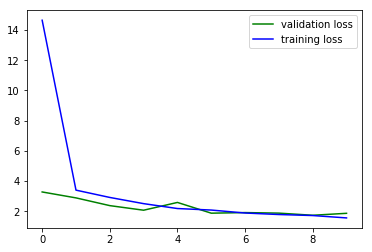

In [126]:
val_rms = np.sqrt(hist2.history['val_loss']) * 48
train_rms = np.sqrt(hist2.history['loss']) * 48

plt.plot(val_rms, 'g-')
plt.plot(train_rms, 'b-')
plt.legend(['validation loss','training loss'])

In [33]:
test_data, test_labels = load_data(test=True)
# test_data.shape

(1783, 96, 96, 1)


In [34]:
pred = model.predict(test_data)
pred[0]

array([ 0.40247488, -0.22656041, -0.38697672, -0.22644371,  0.24091661,
       -0.21433936,  0.53709966, -0.20923966, -0.25152946, -0.22004797,
       -0.52957904, -0.21246672,  0.18724892, -0.4100622 ,  0.669372  ,
       -0.39321533, -0.1939341 , -0.41158402, -0.66316056, -0.3833336 ,
       -0.01537063,  0.16434748,  0.30589762,  0.5892661 , -0.31652635,
        0.59643745, -0.0273586 ,  0.49988285, -0.02128065,  0.7579966 ],
      dtype=float32)

In [35]:
idx = np.random.randint(0, len(test_data), 16)

In [36]:
test_sample = test_data[idx, :, :, :]
pred_sample = pred[idx, :]

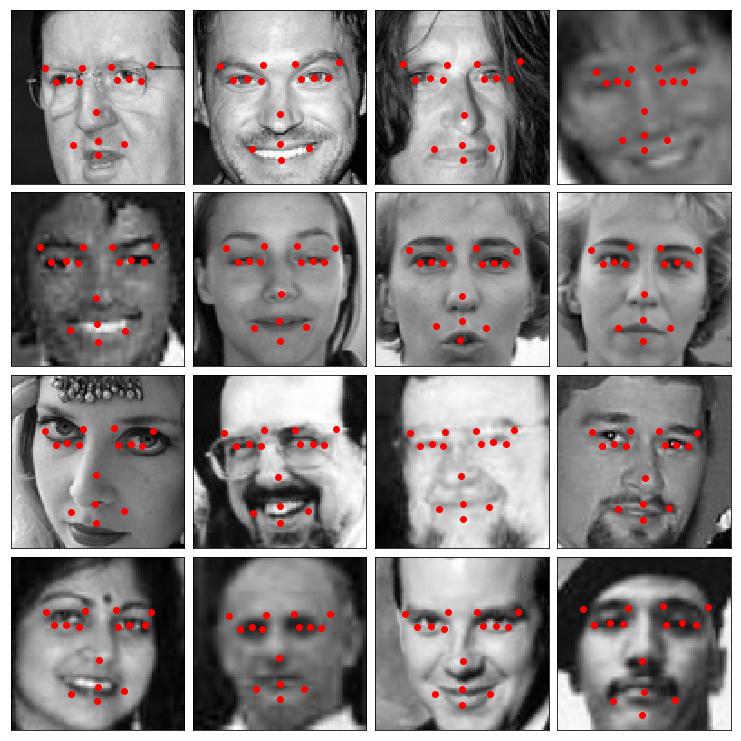

In [37]:
plot_sample(test_sample, pred_sample)